# Modules import

In [1]:
import os
from typing import Dict

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from spellchecker import SpellChecker
from spacytextblob.spacytextblob import SpacyTextBlob

import spacy
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Piotrek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Required commands
`` python -m textblob.download_corpora ``
`` python -m spacy download en_core_web_sm ``

# Data import

In [2]:
DATA_PATH = os.path.join('..', 'data', 'original')
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
validation = pd.read_csv(os.path.join(DATA_PATH, 'validation.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
train.head()

,screen_name,text,account.type,class_type
0,bot#9,YEA now that note GOOD,bot,others
1,human#17,Listen to This Charming Man by The Smiths htt...,human,human
2,bot#23,wish i can i would be seeing other hoes on the...,bot,others
3,bot#1,The decade in the significantly easier schedul...,bot,others
4,bot#11,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn


# Simple Checkup

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20712 entries, 0 to 20711
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   screen_name   20712 non-null  object
 1   text          20712 non-null  object
 2   account.type  20712 non-null  object
 3   class_type    20712 non-null  object
dtypes: object(4)
memory usage: 647.4+ KB


In [4]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   screen_name   2302 non-null   object
 1   text          2302 non-null   object
 2   account.type  2302 non-null   object
 3   class_type    2302 non-null   object
dtypes: object(4)
memory usage: 72.1+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   screen_name   2558 non-null   object
 1   text          2558 non-null   object
 2   account.type  2558 non-null   object
 3   class_type    2558 non-null   object
dtypes: object(4)
memory usage: 80.1+ KB


Everything seems to be in order. No missing values.

# Data exploration

In [6]:
dataset_dict = {
    'train': train,
    'validation': validation,
    'test': test
}

## Word occurence

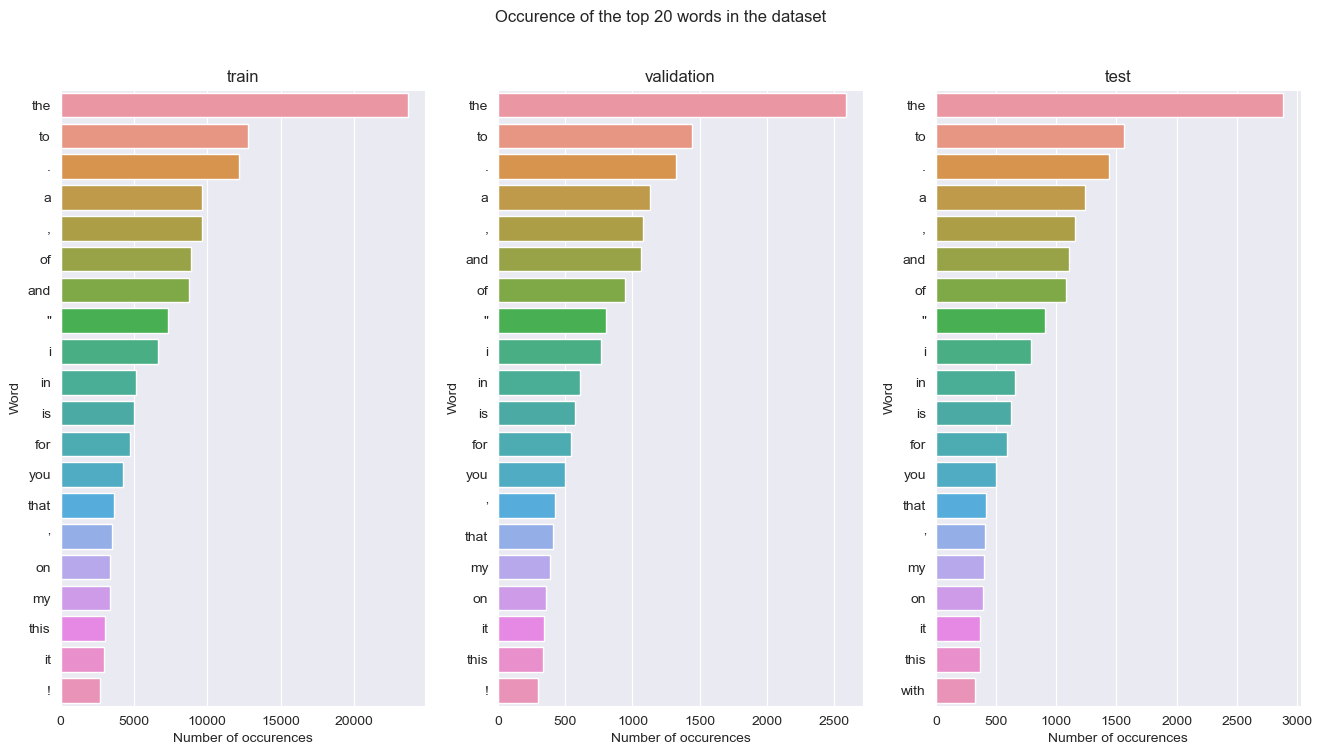

In [7]:
def plot_3_plots_side_by_side(dict_datasets: Dict[str, pd.DataFrame], plot_function: callable):
    """
    Plot 3 plots side by side.
    :param dict_datasets: Dictionary of datasets to plot
    :param plot_function: Function to plot the data
    :return: Figure with 3 plots side by side
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 8))
    for i, (name, dataset) in enumerate(dict_datasets.items()):
        plot_function(dataset, axes[i])
        axes[i].set_title(name)
    return fig


def plot_occurence_of_words(dataset: pd.DataFrame, ax: plt.Axes):
    """
    Plot the occurence of the top 20 words in the dataset.
    :param dataset: Dataset to plot
    :param ax: Axis to plot on
    :return: Axis with the plot
    """

    tweet_tokenizer = TweetTokenizer(strip_handles=True)
    tokenized_words = [tweet_tokenizer.tokenize(text) for text in dataset['text']]
    counter = {}
    for text in tokenized_words:
        for word in text:
            counter[word.lower()] = counter.get(word.lower(), 0) + 1
    word_counts = pd.DataFrame(list(counter.items()), columns=['word', 'occurence'])
    word_counts.sort_values(by='occurence', ascending=False, inplace=True)
    sns.barplot(y='word', x='occurence', data=word_counts.iloc[0:20], ax=ax, orient='h')
    ax.set_ylabel('Word')
    ax.set_xlabel('Number of occurences')


fig = plot_3_plots_side_by_side(dataset_dict, plot_occurence_of_words)
fig.suptitle('Occurence of the top 20 words in the dataset')
plt.show()

As expected, the most common words are stopwords. We will remove them in the next visualization.

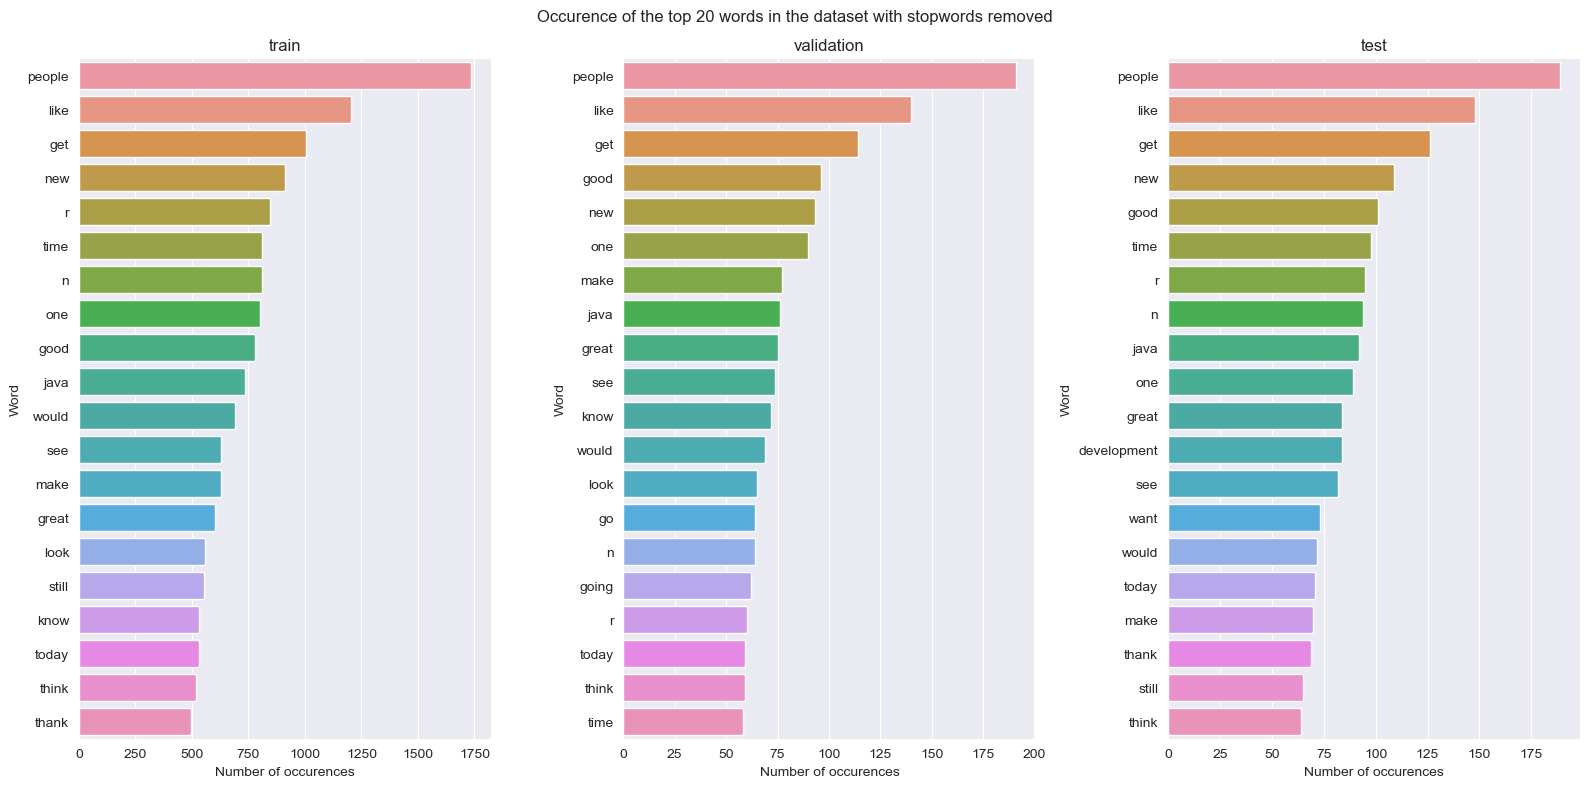

In [8]:
STOPWORDS = set(stopwords.words('english'))


def plot_occurence_of_words_with_stopwords_removed(dataset: pd.DataFrame, ax: plt.Axes):
    """
    Plot the occurence of the top 20 words in the dataset with stopwords removed.
    :param dataset: Dataset to plot
    :param ax: axis to plot on
    :return: axis with the plot
    """
    tweet_tokenizer = TweetTokenizer(strip_handles=True)
    tokenized_words = [tweet_tokenizer.tokenize(text) for text in dataset['text']]
    counter = {}
    for text in tokenized_words:
        for word in text:
            if word.lower() not in STOPWORDS and word.isalpha():
                counter[word.lower()] = counter.get(word.lower(), 0) + 1
    word_counts = pd.DataFrame(list(counter.items()), columns=['word', 'occurence'])
    word_counts.sort_values(by='occurence', ascending=False, inplace=True)
    sns.barplot(y='word', x='occurence', data=word_counts.iloc[0:20], ax=ax, orient='h')
    ax.set_ylabel('Word')
    ax.set_xlabel('Number of occurences')


fig = plot_3_plots_side_by_side(dataset_dict, plot_occurence_of_words_with_stopwords_removed)
fig.suptitle('Occurence of the top 20 words in the dataset with stopwords removed')
fig.tight_layout()
plt.show()

The most common words are now more meaningful. We can see that the most common words are similar in all datasets.

## Class occurence

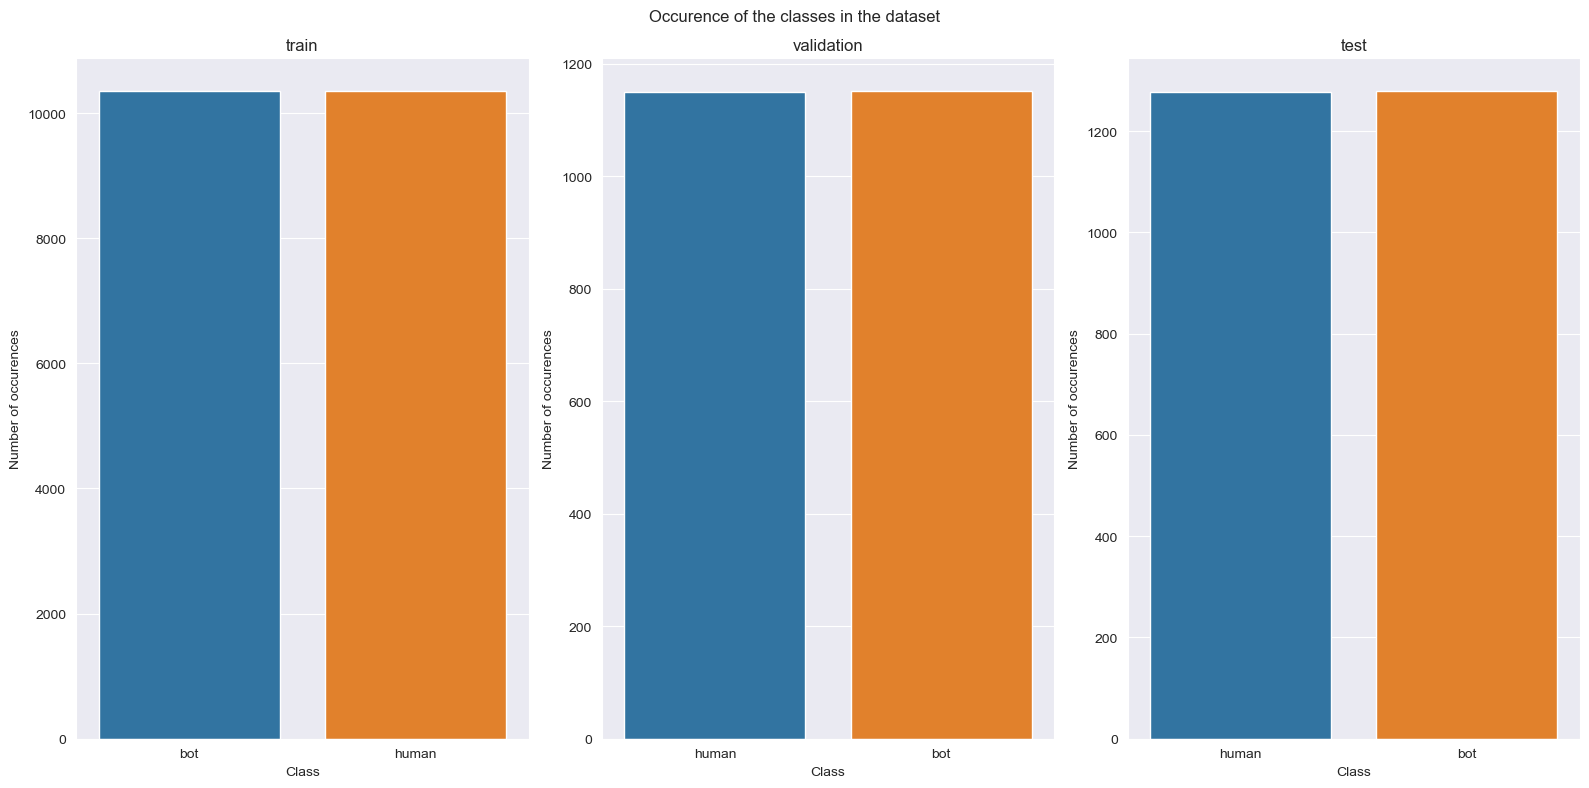

In [9]:
def plot_class_occurence(dataset: pd.DataFrame, ax: plt.Axes):
    """
    Plot the occurence of the classes in the dataset.
    :param dataset: Dataset to plot
    :param ax: Axis to plot on
    :return: Axis with the plot
    """
    sns.countplot(x='account.type', data=dataset, ax=ax)
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of occurences')


fig = plot_3_plots_side_by_side(dataset_dict, plot_class_occurence)
fig.suptitle('Occurence of the classes in the dataset')
fig.tight_layout()
plt.show()

Dataset is balanced.

## Class type occurence

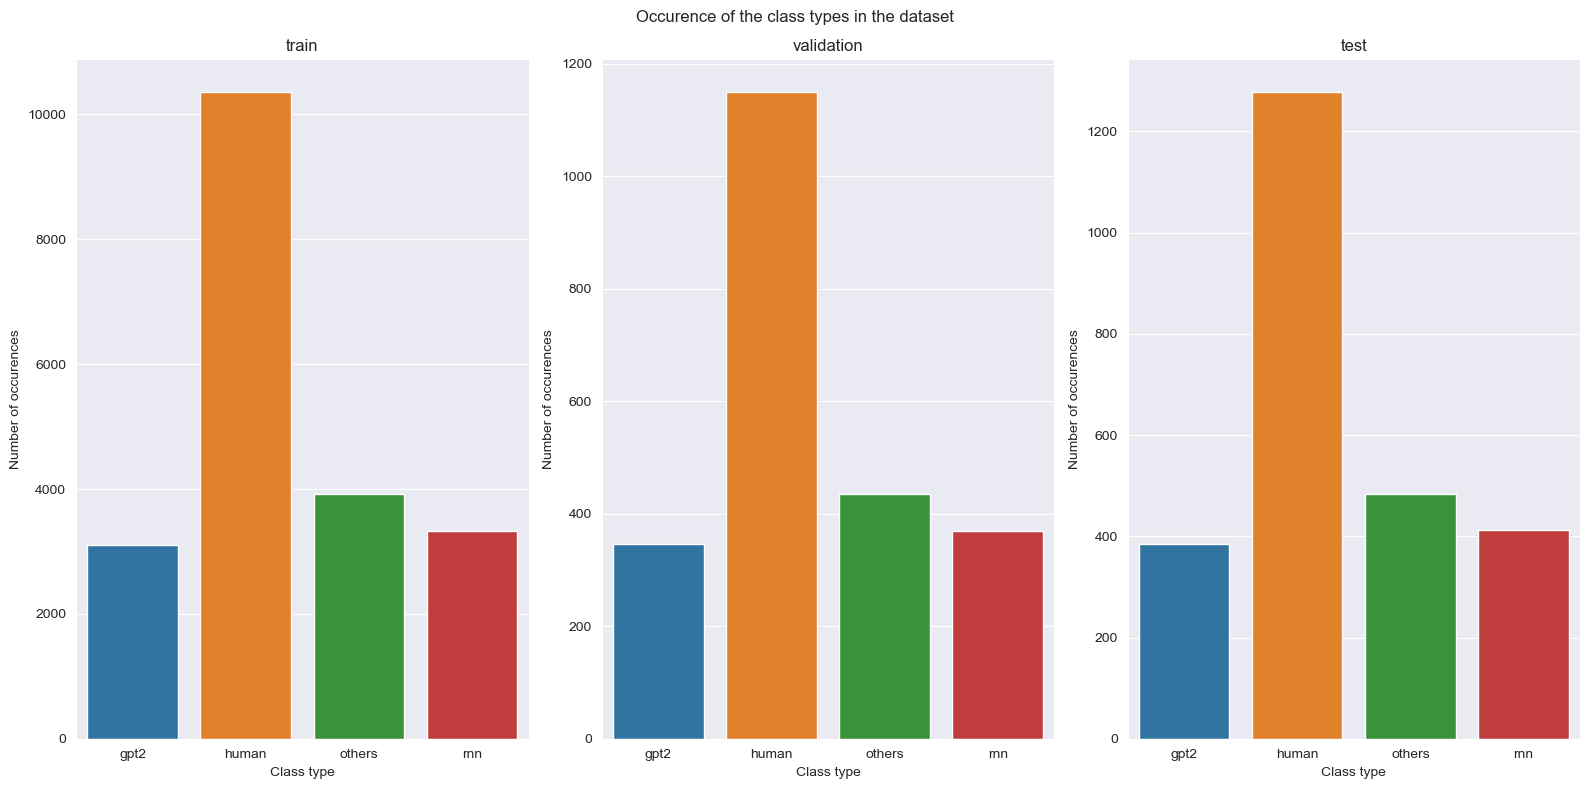

In [10]:
def plot_class_type_occurence(dataset: pd.DataFrame, ax: plt.Axes):
    sns.countplot(x='class_type', data=dataset.sort_values("class_type"), ax=ax)
    ax.set_xlabel('Class type')
    ax.set_ylabel('Number of occurences')


fig = plot_3_plots_side_by_side(dataset_dict, plot_class_type_occurence)
fig.suptitle('Occurence of the class types in the dataset')
fig.tight_layout()
plt.show()

It seems that the dataset has similar usage of different types of generating tweets.

## Tweet length

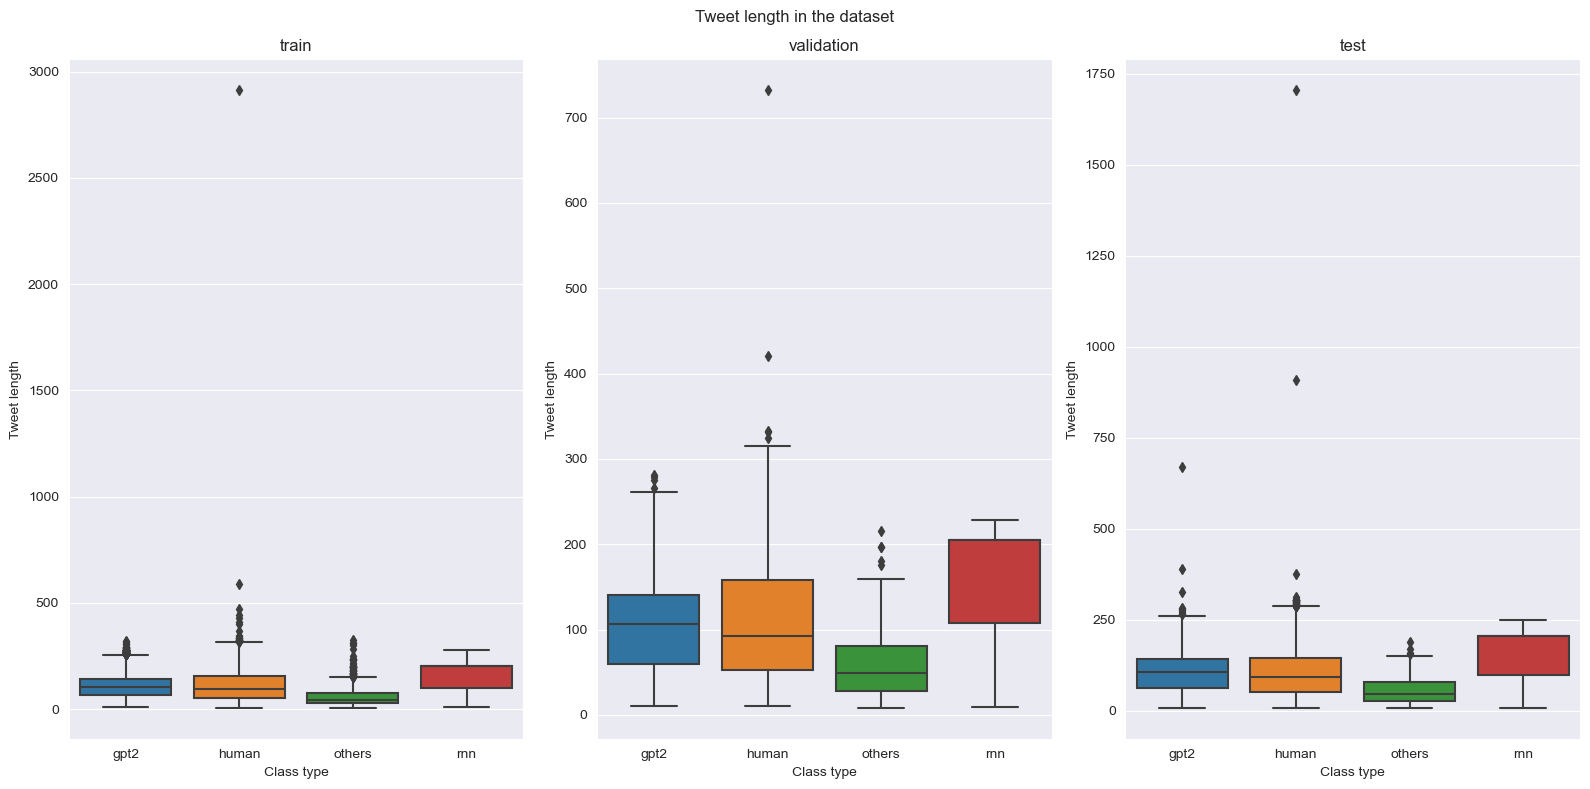

In [11]:
def plot_tweet_length(dataset: pd.DataFrame, ax: plt.Axes):
    mod_df = dataset.copy()
    mod_df["length"] = mod_df["text"].str.len()
    sns.boxplot(mod_df.sort_values(by="class_type"), x="class_type", y="length", ax=ax)
    ax.set_xlabel('Class type')
    ax.set_ylabel('Tweet length')


fig = plot_3_plots_side_by_side(dataset_dict, plot_tweet_length)
fig.suptitle('Tweet length in the dataset')
fig.tight_layout()
plt.show()

The tweet length is similar in all datasets. But we can see that the tweets generated by RNN are longer than the other ones.
Next, we have a tweet generated by GPT-2 followed by humans and the tweets generated by the other techniques.

## URL occurence

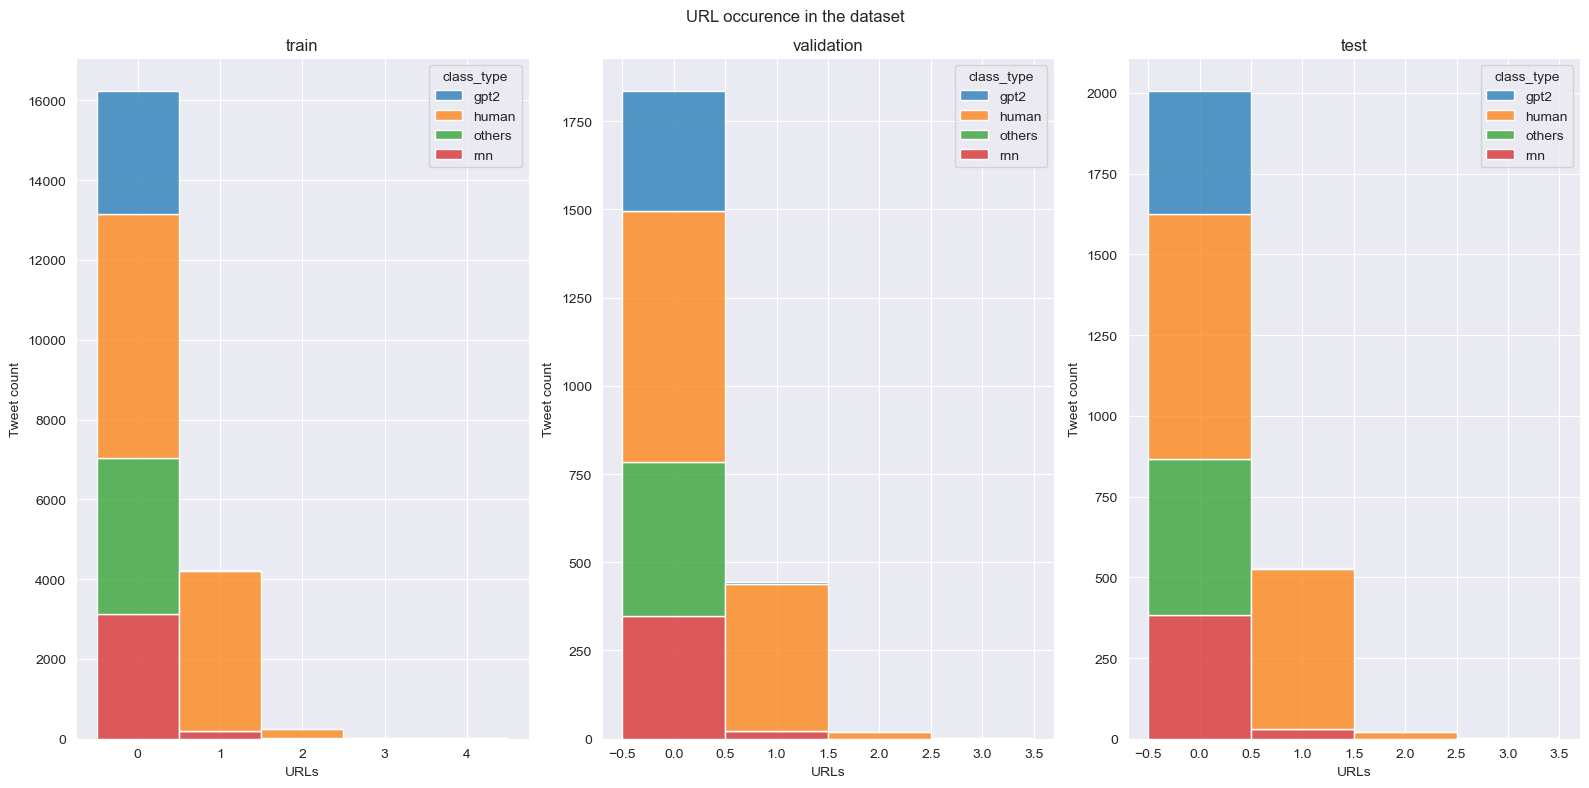

In [12]:
def replace_hyperlinks(tweet):
    """
    Replace hyperlinks with <URL> tag.
    :param tweet: tweet to replace hyperlinks in
    :return: tweet with hyperlinks replaced
    """
    tweet = re.sub(r'https?://[^\s\n\r]+', '<URL>', tweet)
    return tweet


def plot_url_occurence(dataset: pd.DataFrame, ax: plt.Axes):
    """
    Plot the occurence of the URLs in the dataset.
    :param dataset: Dataset to plot
    :param ax: Axis to plot on
    :return: Axis with the plot
    """
    mod_df = dataset.copy()
    mod_df["text"] = mod_df["text"].apply(replace_hyperlinks)
    mod_df["url_count"] = mod_df["text"].str.count("<URL>")
    sns.histplot(x="url_count", discrete=True, hue="class_type", data=mod_df.sort_values(by="class_type"), ax=ax,
                 multiple="stack")
    ax.set_xlabel('URLs')
    ax.set_ylabel('Tweet count')


fig = plot_3_plots_side_by_side(dataset_dict, plot_url_occurence)
fig.suptitle('URL occurence in the dataset')
fig.tight_layout()
plt.show()

As expected, the tweets generated by humans have URLs in them. The tweets generated by bots mainly do not have URLs. Only RNN generated tweets have URLs in them.

## Mentions occurence

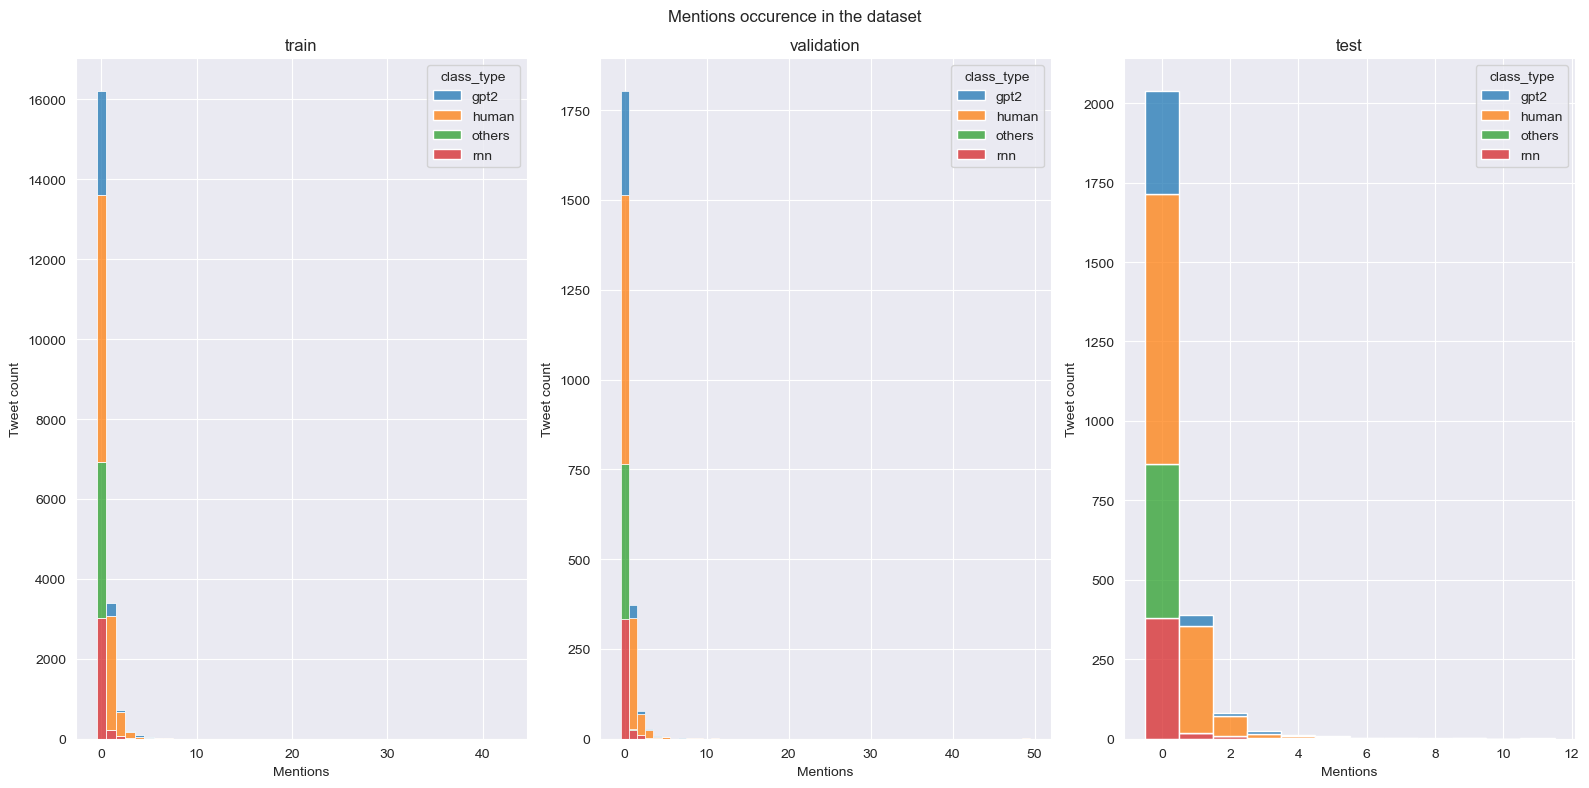

In [13]:
def replace_mentions(tweet):
    """
    Replace mentions with <MENTION> tag.
    :param tweet: Tweet to replace mentions in
    :return: Tweet with mentions replaced
    """
    tweet = re.sub(r'@[^\s\n\r]+', '<MENTION>', tweet)
    return tweet


def plot_mentions_occurence(dataset: pd.DataFrame, ax: plt.Axes):
    """
    Plot the occurence of the mentions in the dataset.
    :param dataset: Dataset to plot
    :param ax: Axis to plot on
    :return: Axis with the plot
    """
    mod_df = dataset.copy()
    mod_df["text"] = mod_df["text"].apply(replace_mentions)
    mod_df["mention_count"] = mod_df["text"].str.count("<MENTION>")
    sns.histplot(x="mention_count", discrete=True, hue="class_type", data=mod_df.sort_values(by="class_type"), ax=ax,
                 multiple="stack")
    ax.set_xlabel('Mentions')
    ax.set_ylabel('Tweet count')


fig = plot_3_plots_side_by_side(dataset_dict, plot_mentions_occurence)
fig.suptitle('Mentions occurence in the dataset')
fig.tight_layout()
plt.show()

Similar to the URLs, the tweets generated by humans have mentions in them. The tweets generated by bots mainly do not have mentions. But the tweets generated by RNN and GPT-2 have mentions in them (significantly fewer tweets than humans).

## Emojis occurence

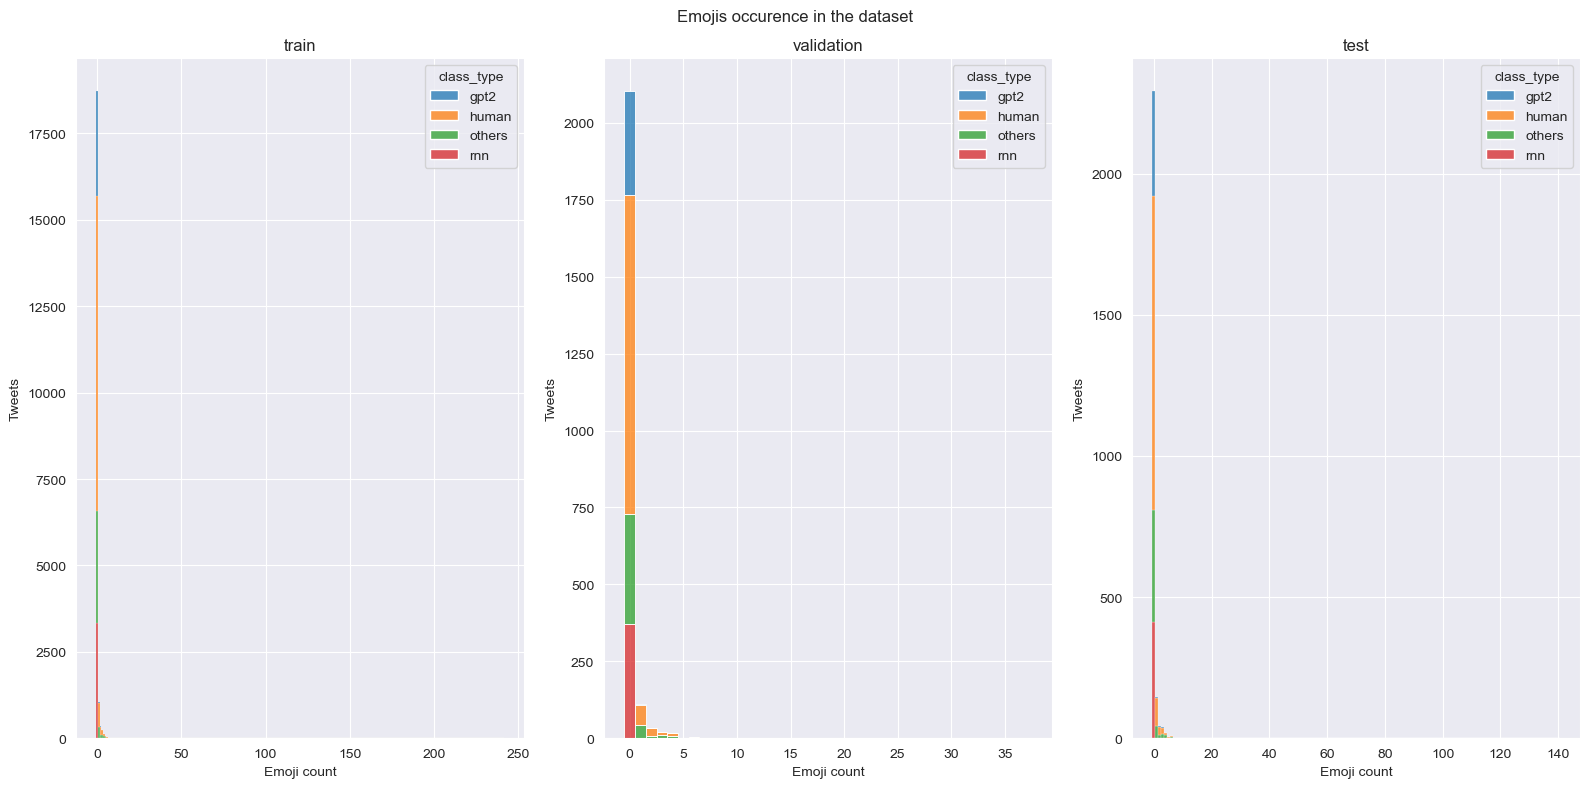

In [14]:
def plot_emoji_occurrence(dataset: pd.DataFrame, ax: plt.Axes):
    """
    Plot the occurence of the emojis in the dataset.
    :param dataset: Dataset to plot
    :param ax: Axis to plot on
    :return: Axis with the plot
    """
    mod_df = dataset.copy()
    mod_df["emoji_count"] = mod_df["text"].apply(lambda x: len(re.findall(r'<U\+[0-9A-F]+>', x)))
    sns.histplot(x="emoji_count", discrete=True, hue="class_type", data=mod_df.sort_values(by="class_type"), ax=ax,
                 multiple="stack")
    ax.set_xlabel('Emoji count')
    ax.set_ylabel('Tweets')


fig = plot_3_plots_side_by_side(dataset_dict, plot_emoji_occurrence)
fig.suptitle('Emojis occurence in the dataset')
fig.tight_layout()
plt.show()

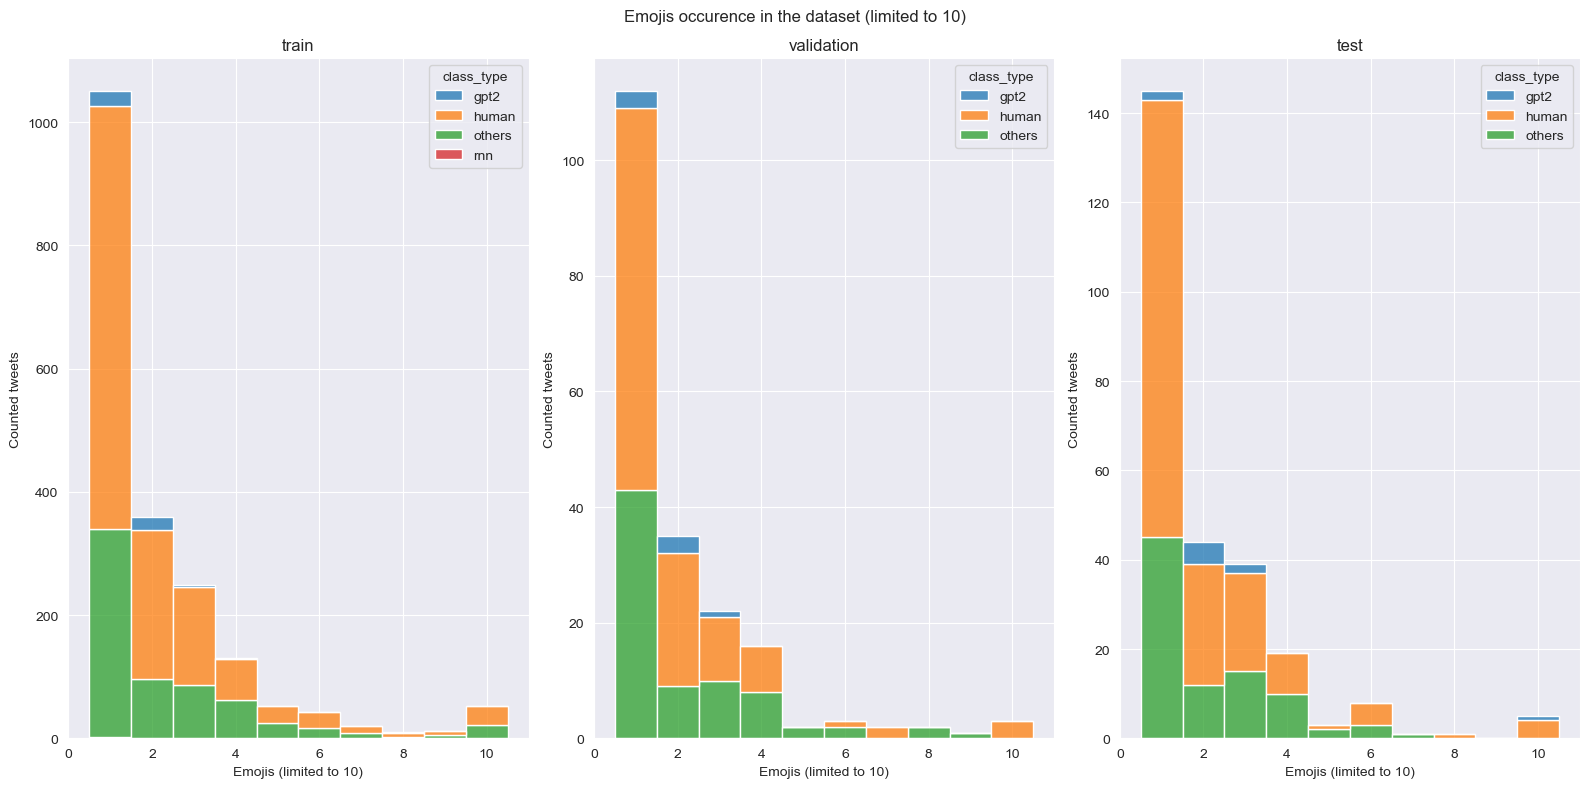

In [15]:
def plot_emoji_occurrence_limit(dataset: pd.DataFrame, ax: plt.Axes, limit: int = 10):
    """
    Plot the occurence of the emojis in the dataset and remove zeros, and limit outputs.
    :param limit: limit of emojis to plot
    :param dataset: Dataset to plot
    :param ax: Axis to plot on
    :return: Axis with the plot
    """
    mod_df = dataset.copy()
    mod_df["emoji_count"] = mod_df["text"].apply(
        lambda x: len(re.findall(r'<U\+[0-9A-F]+>', x)) if len(re.findall(r'<U\+[0-9A-F]+>', x)) < limit else limit)
    mod_df = mod_df[mod_df["emoji_count"] != 0]
    sns.histplot(x="emoji_count", discrete=True, hue="class_type", data=mod_df.sort_values(by="class_type"), ax=ax,
                 multiple="stack")
    ax.set_ylabel('Counted tweets')
    ax.set_xlabel('Emojis (limited to 10)')


fig = plot_3_plots_side_by_side(dataset_dict, plot_emoji_occurrence_limit)
fig.suptitle('Emojis occurence in the dataset (limited to 10)')
fig.tight_layout()
plt.show()

The tweets generated by humans have emojis in them. The tweets generated by bots mainly do not have emojis. But the tweets generated by other have emojis in them (significantly fewer tweets than humans).

## Misspellings occurence

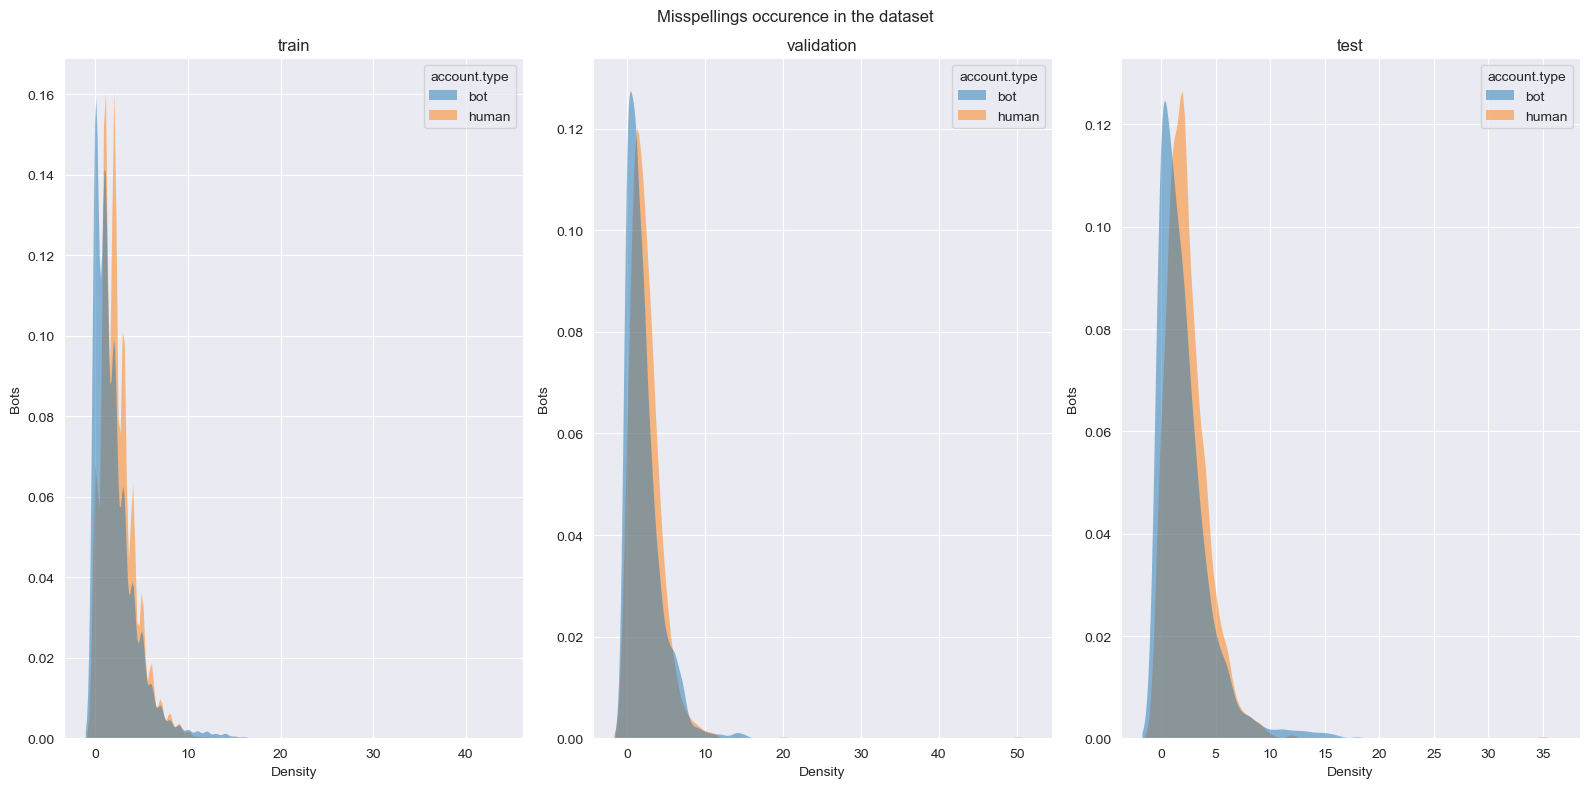

In [16]:

spell = SpellChecker()


def plot_misspellings_occurence(dataset: pd.DataFrame, ax: plt.Axes):
    """
    Plot the occurence of the misspellings in the dataset.
    :param dataset: Dataset to plot
    :param ax: Axis to plot on
    :return: Axis with the plot
    """
    mod_df = dataset.copy()
    tweet_tokenizer = TweetTokenizer()
    mod_df["misspelling_count"] = mod_df["text"].apply(lambda x: len(spell.unknown(tweet_tokenizer.tokenize(x))))
    sns.kdeplot(x="misspelling_count", hue="account.type", data=mod_df.sort_values(by="account.type"), ax=ax,
                multiple="layer", fill=True, alpha=.5, linewidth=0)
    ax.set_xlabel('Density')
    ax.set_ylabel('Bots')


fig = plot_3_plots_side_by_side(dataset_dict, plot_misspellings_occurence)
fig.suptitle('Misspellings occurence in the dataset')
fig.tight_layout()
plt.show()

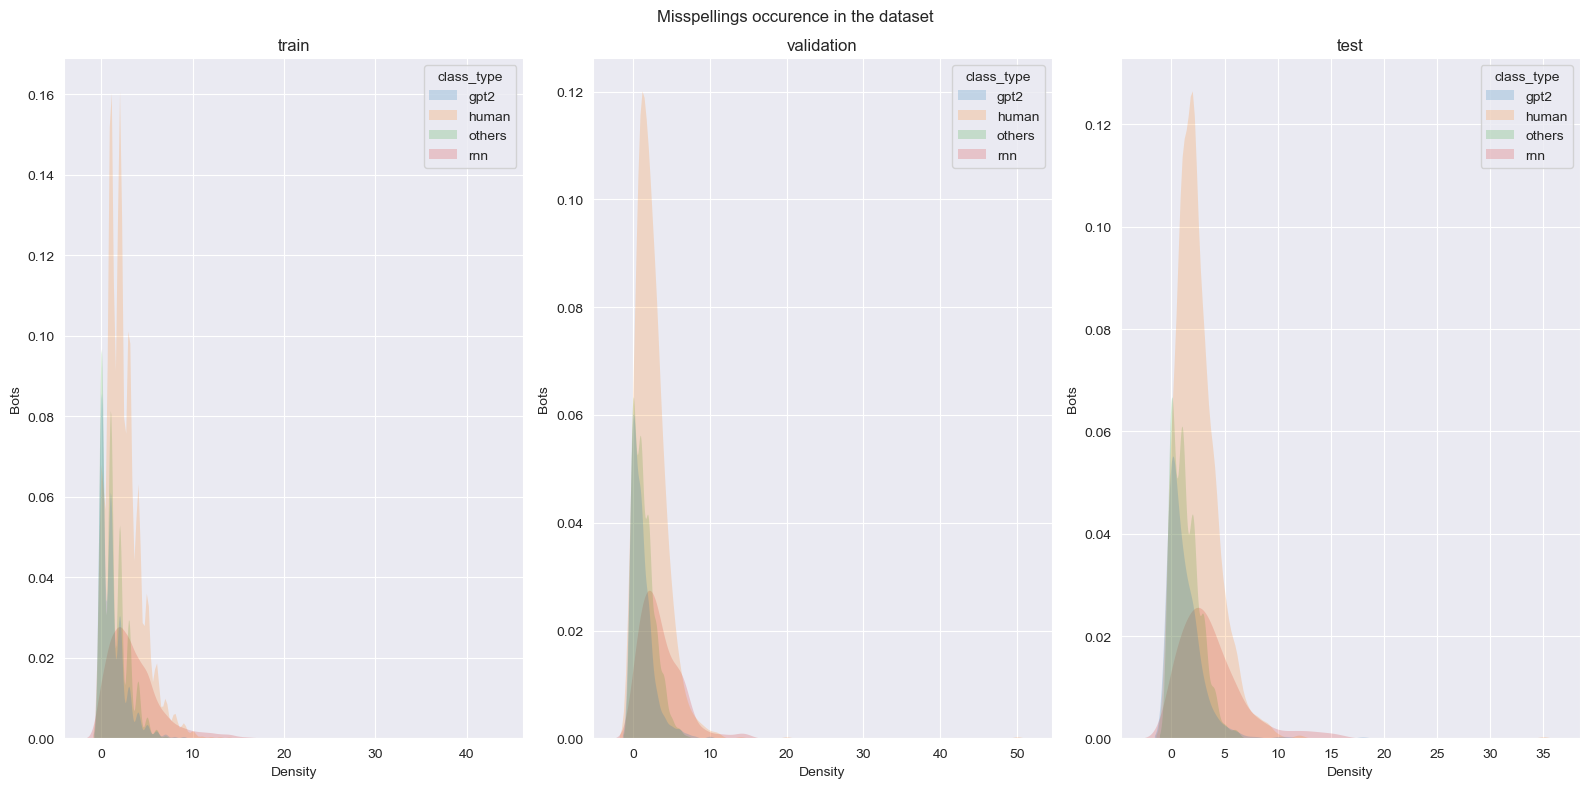

In [17]:
from spellchecker import SpellChecker

spell = SpellChecker()


def plot_misspellings_occurence(dataset: pd.DataFrame, ax: plt.Axes):
    """
    Plot the occurence of the misspellings in the dataset.
    :param dataset: Dataset to plot
    :param ax: Axis to plot on
    :return: Axis with the plot
    """
    mod_df = dataset.copy()
    tweet_tokenizer = TweetTokenizer()
    mod_df["misspelling_count"] = mod_df["text"].apply(lambda x: len(spell.unknown(tweet_tokenizer.tokenize(x))))
    sns.kdeplot(x="misspelling_count", hue="class_type", data=mod_df.sort_values(by="class_type"), ax=ax,
                multiple="layer", fill=True, alpha=.2, linewidth=0)
    ax.set_xlabel('Density')
    ax.set_ylabel('Bots')


fig = plot_3_plots_side_by_side(dataset_dict, plot_misspellings_occurence)
fig.suptitle('Misspellings occurence in the dataset')
fig.tight_layout()
plt.show()

## Sentiment analysis of the tweets

In [18]:
# Load the spacy model
nlp = spacy.load('en_core_web_sm')
# Add the textblob extension to the pipeline
nlp.add_pipe("spacytextblob")


def add_polarity_subjectivity_to_tweets(df: pd.DataFrame) -> pd.DataFrame:
    """
        Add polarity and subjectivity to the tweets in the dataset.
        :param df: Dataset to add polarity and subjectivity to
        :return: Dataset with polarity and subjectivity added
    """
    docs = [nlp(text) for text in df['text']]
    df['polarity'] = [doc._.blob.polarity for doc in docs]
    df['subjectivity'] = [doc._.blob.subjectivity for doc in docs]
    return df


train = add_polarity_subjectivity_to_tweets(train)
validation = add_polarity_subjectivity_to_tweets(validation)
test = add_polarity_subjectivity_to_tweets(test)
train.head()

,screen_name,text,account.type,class_type,polarity,subjectivity
0,bot#9,YEA now that note GOOD,bot,others,0.7000,0.6000
1,human#17,Listen to This Charming Man by The Smiths htt...,human,human,0.7000,1.0000
2,bot#23,wish i can i would be seeing other hoes on the...,bot,others,-0.5625,0.6875
3,bot#1,The decade in the significantly easier schedul...,bot,others,0.3750,0.8750
4,bot#11,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn,0.0000,0.0000


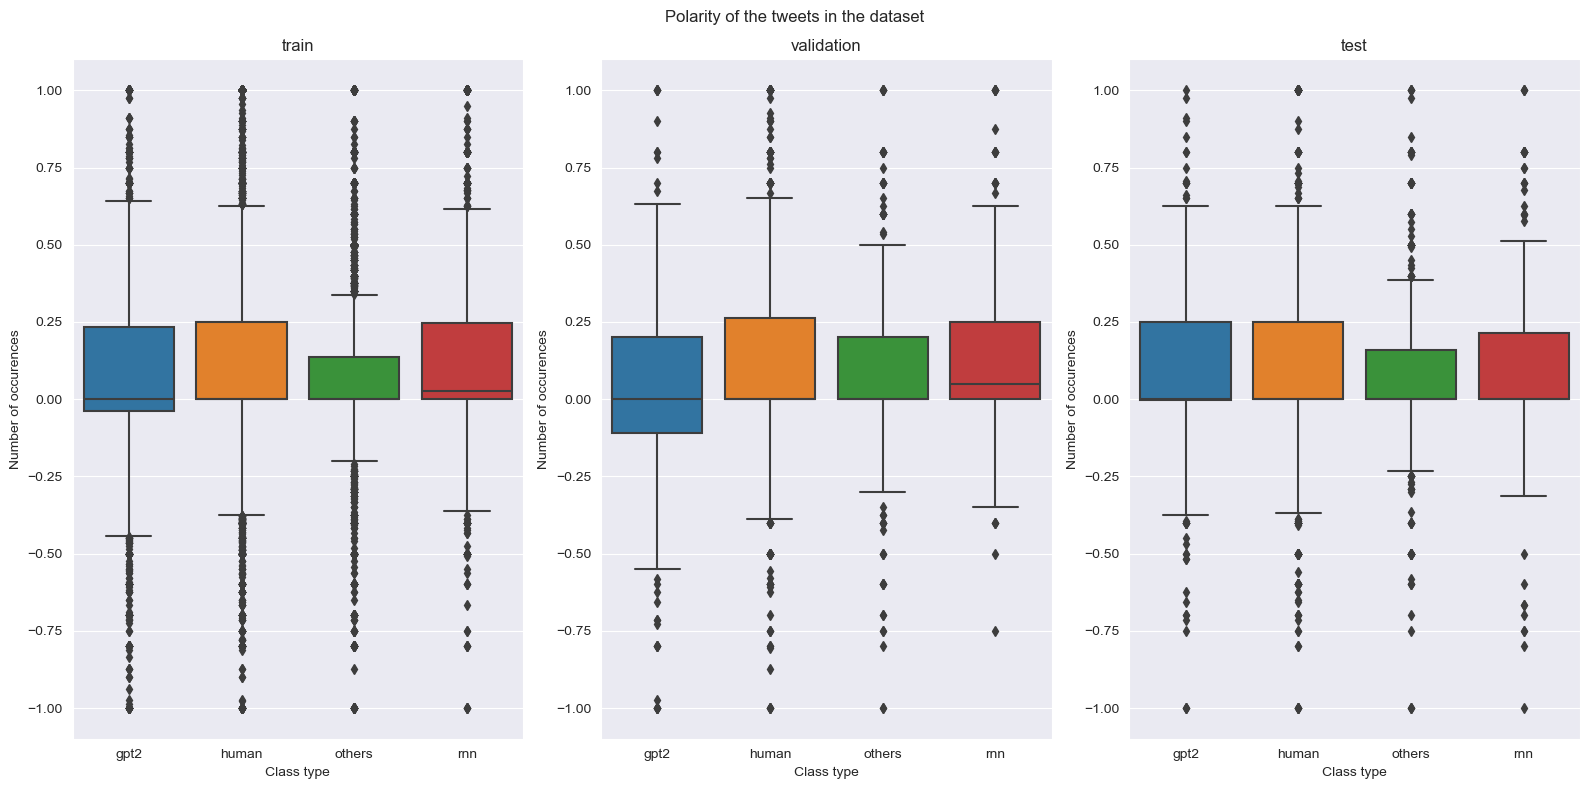

In [19]:
def plot_polarity(dataset: pd.DataFrame, ax: plt.Axes):
    """
    Plot the polarity of the tweets in the dataset.
    :param dataset: Dataset to plot
    :param ax: Axis to plot on
    :return: Axis with the plot
    """
    sns.boxplot(dataset.sort_values(by='class_type'), x='class_type', y="polarity", ax=ax)
    ax.set_xlabel('Class type')
    ax.set_ylabel('Number of occurences')


fig = plot_3_plots_side_by_side(dataset_dict, plot_polarity)
fig.suptitle('Polarity of the tweets in the dataset')
fig.tight_layout()
plt.show()

The polarity of the tweets is similar in all cases. 

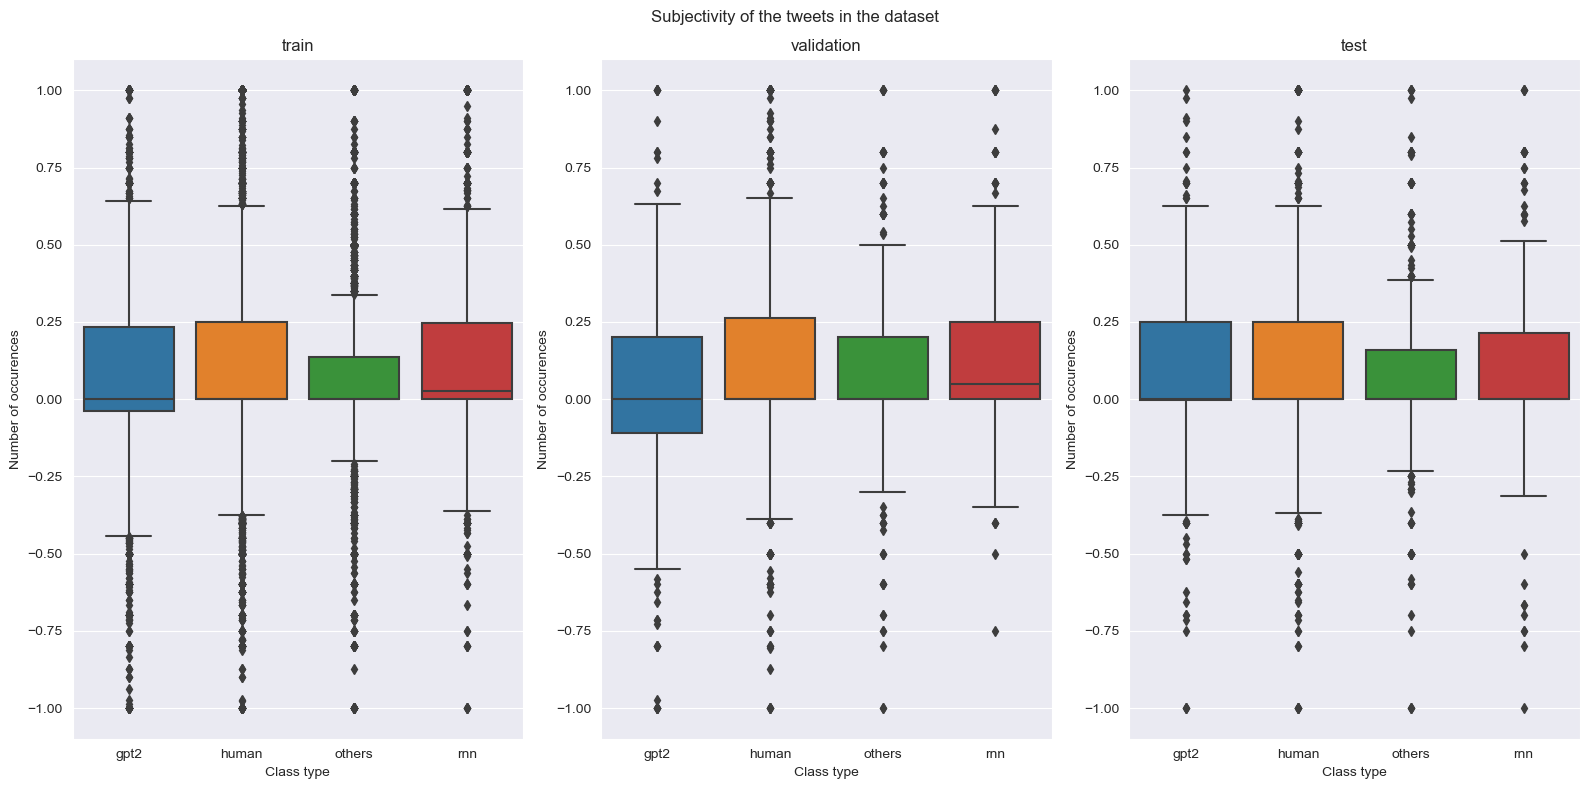

In [20]:
def plot_subjectivity(dataset: pd.DataFrame, ax: plt.Axes):
    """
    Plot the subjectivity of the tweets in the dataset.
    :param dataset: Dataset to plot
    :param ax: Axis to plot on
    :return: Axis with the plot
    """
    sns.violinplot(dataset.sort_values(by='class_type'), x='class_type', y="subjectivity", points=True, ax=ax)
    ax.set_xlabel('Class type')
    ax.set_ylabel('Number of occurences')


fig = plot_3_plots_side_by_side(dataset_dict, plot_polarity)
fig.suptitle('Subjectivity of the tweets in the dataset')
fig.tight_layout()
plt.show()

The same goes for the subjectivity of the tweets.